In [1]:
import pandas as pd
import numpy as np
from faker import Faker

# Set random seed for reproducibility
np.random.seed(42)
fake = Faker()

# Define the number of customers
n_customers = 1000

# Generate customer data
data = {
    'CustomerID': range(1, n_customers + 1),
    'Age': np.random.randint(18, 80, n_customers),
    'Gender': np.random.choice(['Male', 'Female'], n_customers),
    'Tenure': np.random.randint(0, 10, n_customers),
    'Usage': np.random.uniform(0, 1000, n_customers).round(2),
    'MonthlyCharges': np.random.uniform(20, 100, n_customers).round(2),
    'TotalCharges': np.zeros(n_customers),
    'Contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], n_customers),
    'PaperlessBilling': np.random.choice(['Yes', 'No'], n_customers),
    'PaymentMethod': np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'], n_customers),
    'Churn': np.random.choice([0, 1], n_customers, p=[0.7, 0.3])  # 30% churn rate
}

# Calculate TotalCharges
data['TotalCharges'] = data['MonthlyCharges'] * data['Tenure']

# Create DataFrame
df = pd.DataFrame(data)

# Add some correlation between features and churn
df.loc[df['Tenure'] <= 2, 'Churn'] = np.random.choice([0, 1], sum(df['Tenure'] <= 2), p=[0.4, 0.6])
df.loc[df['MonthlyCharges'] > 80, 'Churn'] = np.random.choice([0, 1], sum(df['MonthlyCharges'] > 80), p=[0.5, 0.5])

# Save to CSV
df.to_csv('customer_data.csv', index=False)

print("Dataset created and saved as 'customer_data.csv'")

Dataset created and saved as 'customer_data.csv'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        1000 non-null   int64  
 1   Age               1000 non-null   int64  
 2   Gender            1000 non-null   object 
 3   Tenure            1000 non-null   int64  
 4   Usage             1000 non-null   float64
 5   MonthlyCharges    1000 non-null   float64
 6   TotalCharges      1000 non-null   float64
 7   Contract          1000 non-null   object 
 8   PaperlessBilling  1000 non-null   object 
 9   PaymentMethod     1000 non-null   object 
 10  Churn             1000 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 86.1+ KB
None
        CustomerID          Age       Tenure        Usage  MonthlyCharges  \
count  1000.000000  1000.000000  1000.000000  1000.000000     1000.000000   
mean    500.500000    49.857000     4.411000   505.686340    

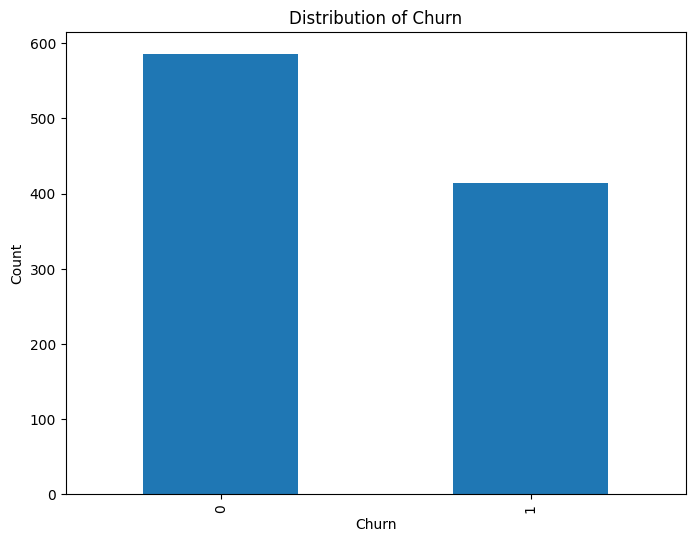

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data (assuming you have a CSV file)
df = pd.read_csv('customer_data.csv')

# Display basic information about the dataset
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Visualize the distribution of the target variable (churn)
plt.figure(figsize=(8, 6))
df['Churn'].value_counts().plot(kind='bar')
plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Handle missing values (if any)
df = df.dropna()  # or use imputation techniques

# Convert categorical variables to numeric
df = pd.get_dummies(df, drop_first=True)

# Split features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [4]:
from models import train_logistic_regression, train_random_forest, train_neural_network, evaluate_model

# Train and evaluate logistic regression
lr_model = train_logistic_regression(X_train, y_train)
lr_metrics = evaluate_model(lr_model, X_test, y_test)
print("Logistic Regression Metrics:", lr_metrics)

# Train and evaluate random forest
rf_model = train_random_forest(X_train, y_train)
rf_metrics = evaluate_model(rf_model, X_test, y_test)
print("Random Forest Metrics:", rf_metrics)

# Train and evaluate neural network
nn_model = train_neural_network(X_train, y_train)
nn_metrics = evaluate_model(nn_model, X_test, y_test)
print("Neural Network Metrics:", nn_metrics)

Logistic Regression Metrics: {'accuracy': 0.66, 'precision': 0.5857142857142857, 'recall': 0.5125, 'f1': 0.5466666666666666}
Random Forest Metrics: {'accuracy': 0.595, 'precision': 0.49333333333333335, 'recall': 0.4625, 'f1': 0.4774193548387097}
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Neural Network Metrics: {'accuracy': 0.63, 'precision': 0.5333333333333333, 'recall': 0.6, 'f1': 0.5647058823529412}


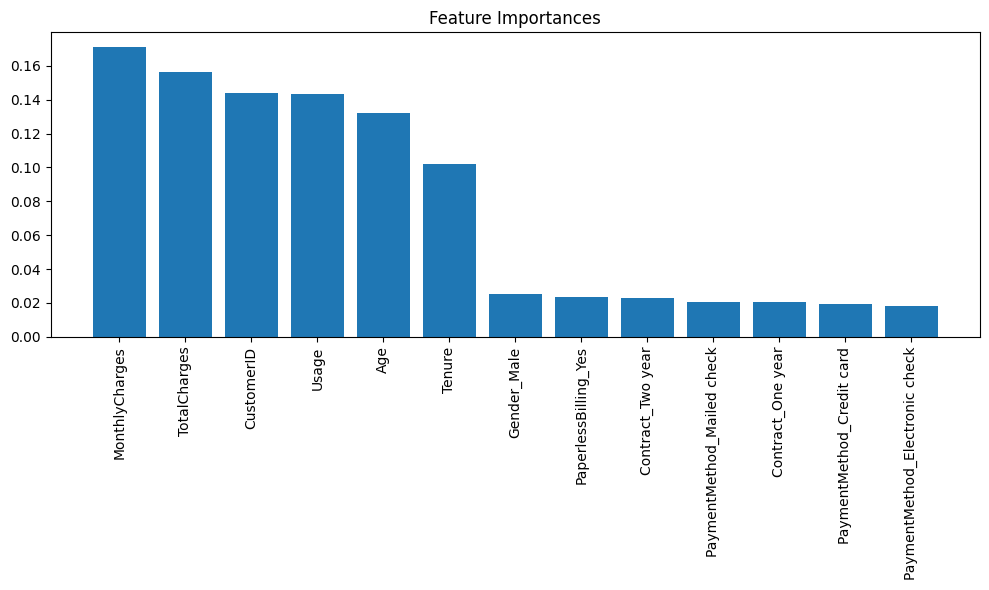

In [5]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, X):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = X.columns

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(X.shape[1]), importances[indices])
    plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

plot_feature_importance(rf_model, X)


In [7]:
def export_predictions(model, X, original_data, filename):
    predictions = model.predict(X)
    results = original_data.copy()
    results['Churn_Prediction'] = predictions
    results['Churn_Probability'] = model.predict_proba(X)[:, 1]
    results.to_csv(filename, index=False)

# Export predictions for the best model (assuming random forest performed best)
export_predictions(rf_model, X_test, df.iloc[y_test.index], 'churn_predictions.csv')